In [70]:
import pandas as pd
import numpy as np
from scipy import stats 
import datetime

import matplotlib.pyplot as plt
import seaborn as sns

from scipy.stats import stats


from sklearn import linear_model
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.preprocessing import PolynomialFeatures
from sklearn.preprocessing import StandardScaler
import seaborn as sns

In [79]:
def comma_be_gone_into_int(x):
    return int(x.replace(',',''))

def BoolsInts(x):
    return np.array(list(map(int,x)))

def standardize_scale(x):
    return (x - np.mean(x))/(np.std(x))

In [80]:
df = pd.read_csv("kc_house_data_train.csv", index_col=[0])

df.drop('id', axis = 1, inplace = True)

#### Get rid of outliers

df.loc[df.bedrooms == 33, "bedrooms"] = 3


put in data viz and statistics for seasons and if renovated status

In [81]:
df['yard'] = df.sqft_lot - (df.sqft_living/df.floors)

In [82]:
new_column = []

for x in range(len(df)):
    new_column.append(df.iloc[x].date.split('T')[0][:4] + '-' + df.iloc[x].date.split('T')[0][4:6] + '-' + df.iloc[x].date.split('T')[0][6:])


df['date'] = [datetime.datetime.strptime(new_column[i], '%Y-%m-%d') for i in range(len(new_column))]


df['winter'] = np.array(list(map(int, [df['date'][i].month in [12,1,2] for i in range(len(df))])));
df['spring'] = np.array(list(map(int, [df['date'][i].month in [3,4,5] for i in range(len(df))])));
df['summer'] = np.array(list(map(int, [df['date'][i].month in [6,7,8] for i in range(len(df))])));
#df['autumn'] = np.array(list(map(int, [df['date'][i].month in [9,10,11] for i in range(len(df))])));
df.drop('date',axis=1, inplace = True)

In [83]:
df['renovated']= np.array(list(map(int,df.yr_renovated != 0)))

df.drop(['yr_renovated','yr_built'],axis=1, inplace = True)

-------------------------------------------------------------------------------------

income

--------------------------------------------------

In [84]:
zip_money_df = pd.read_csv('Seatle_Income_Population.csv')

zip_money_df['income'] = [comma_be_gone_into_int(x) for x in zip_money_df.income]

zip_money_df = zip_money_df[['zipcode','income']]


missing_zips_list = list(set(list(df.zipcode))-set(list(zip_money_df.zipcode)))


zip_money_dict = dict(zip(list(zip_money_df.zipcode),list(zip_money_df.income)))


for i in missing_zips_list:
    
    zip_money_dict[i] = sum(zip_money_df.income)/len(zip_money_df)

 
    
incomes_in_df_by_row_list = [[round(zip_money_dict[i])] for i in list(df.zipcode)]

df_income = pd.DataFrame.from_dict(dict(zip(list(df.index),incomes_in_df_by_row_list))).T

df_income.columns = ['income']

df['income'] = df_income 

In [85]:
len(df.columns)

23

-----

latitude longitude punnet

---------------------------------------

In [86]:
mean_lat = df.lat.mean()

mean_long = df.long.mean()

df_lat_long_punnet = pd.concat([df.lat - mean_lat,df.long - mean_long],axis = 1)

df_lat_long_punnet['North_West'] = np.where((df_lat_long_punnet.lat > 0) & (df_lat_long_punnet.long > 0), True, False)

df_lat_long_punnet['North_East'] = np.where((df_lat_long_punnet.lat > 0) & (df_lat_long_punnet.long < 0), True, False) 

df_lat_long_punnet['South_West'] = np.where((df_lat_long_punnet.lat) < 0 & (df_lat_long_punnet.long > 0), True, False) 

df_lat_long_punnet['South_East'] = np.where((df_lat_long_punnet.lat < 0) & (df_lat_long_punnet.long < 0),True, False)  

df_lat_long_punnet.columns = ['lat', 'long','North_West','North_East','South_West','South_East']

df_ordinal = df_lat_long_punnet[['North_West','North_East','South_West','South_East']]

df_ordinal = df_ordinal.apply(BoolsInts)

df_ordinal.drop(['North_West'], axis = 1, inplace = True)

df = pd.concat([df,df_ordinal], axis = 1)

df.drop(['lat','long'],axis = 1, inplace = True)


In [41]:
len(df.columns)

24

---------------------------------------------

Do a Linear Fit.

--------------------

In [42]:
from sklearn.model_selection import train_test_split


X = df.drop(['price'],axis = 1)
y = df.price


X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    test_size=0.2,
                                                    random_state=42)
lr = LinearRegression()

lr.fit(X_train, y_train)

print(lr.score(X_train, y_train))

y_train_pred = lr.predict(X_train)

y_test_pred = lr.predict(X_test)

from sklearn import metrics

train_rmse = np.sqrt(metrics.mean_squared_error(y_train, y_train_pred))

test_rmse = np.sqrt(metrics.mean_squared_error(y_test, y_test_pred))

print('Training Root Mean Squared Error:' , train_rmse)
print('Testing Root Mean Squared Error:' , test_rmse)

0.7026450999556817
Training Root Mean Squared Error: 204700.36759718368
Testing Root Mean Squared Error: 196883.7374649138


--------------

Create the target variable, the df of only the continous variables, and only the the categorical variables. 
Do Polynomials on the continous, and not the categorical variables.  concatenate them. 
do recursive feature eliminaion

--------------------

In [43]:
df.columns

Index(['price', 'bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot', 'floors',
       'waterfront', 'view', 'condition', 'grade', 'sqft_above',
       'sqft_basement', 'zipcode', 'sqft_living15', 'sqft_lot15', 'yard',
       'winter', 'spring', 'summer', 'renovated', 'income', 'North_East',
       'South_West', 'South_East'],
      dtype='object')

In [44]:
continous = ['bedrooms','bathrooms','sqft_living','sqft_lot','floors','sqft_above','sqft_basement','sqft_living15','sqft_lot15','income','yard']

one_hots = ['waterfront','winter','spring','summer','renovated','North_East','South_West','South_East']

categorical = ['view', 'condition', 'grade']



In [45]:
dummy_df = pd.get_dummies(data = df[categorical], columns = categorical, drop_first=True)

In [46]:
df = pd.concat([df,dummy_df], axis = 1)

In [47]:
df.drop(categorical,axis = 1, inplace = True)

In [48]:
len(df.columns)

40

In [49]:
df_features = df[df.drop('zipcode', axis = 1).columns[1:]]



poly_object = PolynomialFeatures(degree=2, include_bias=False)

poly = poly_object.fit_transform(df_features)

poly_columns = poly_object.get_feature_names(df_features.columns)

poly_df = pd.DataFrame(poly, columns = poly_columns)

df = pd.concat([df,poly_df],axis = 1)

In [50]:
len(df.columns)

819

In [51]:
dummy_zip_df = pd.get_dummies(data = df['zipcode'])
df = pd.concat([df,dummy_zip_df], axis = 1)
df.drop('zipcode',axis = 1, inplace = True)



In [52]:
len(dummy_zip_df.columns) 

70

In [53]:
len(df.columns)

888

------------------------------

In [22]:
len(df.columns)

888

---------------------------------------

In [23]:
from sklearn.model_selection import train_test_split


X = df.drop(['price'],axis = 1)
y = df.price


X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    test_size=0.2,
                                                    random_state=42)
lr = LinearRegression()

lr.fit(X_train, y_train)

print(lr.score(X_train, y_train))

y_train_pred = lr.predict(X_train)

y_test_pred = lr.predict(X_test)

from sklearn import metrics

train_rmse = np.sqrt(metrics.mean_squared_error(y_train, y_train_pred))

test_rmse = np.sqrt(metrics.mean_squared_error(y_test, y_test_pred))

print('Training Root Mean Squared Error:' , train_rmse)
print('Testing Root Mean Squared Error:' , test_rmse)

0.912389214058145
Training Root Mean Squared Error: 111111.71756273948
Testing Root Mean Squared Error: 140310.12772682743


---------------------------------------------------------------

Use recursive feature elimination to improve model 

--------------------------------------------------------

In [24]:
from sklearn.feature_selection import RFECV

ols = LinearRegression()


selector = RFECV(estimator=ols, step=10, cv=7, scoring='neg_mean_squared_error', n_jobs=-1, verbose=1)


selector.fit(X_train, y_train)

Fitting estimator with 887 features.
Fitting estimator with 877 features.
Fitting estimator with 867 features.
Fitting estimator with 857 features.
Fitting estimator with 847 features.
Fitting estimator with 837 features.
Fitting estimator with 827 features.
Fitting estimator with 817 features.
Fitting estimator with 807 features.
Fitting estimator with 797 features.
Fitting estimator with 787 features.
Fitting estimator with 777 features.
Fitting estimator with 767 features.
Fitting estimator with 757 features.
Fitting estimator with 747 features.
Fitting estimator with 737 features.
Fitting estimator with 727 features.
Fitting estimator with 717 features.
Fitting estimator with 707 features.


RFECV(cv=7, estimator=LinearRegression(), n_jobs=-1,
      scoring='neg_mean_squared_error', step=10, verbose=1)

In [25]:
selected_rfe = X_train.columns[selector.support_]


lm_rfe = LinearRegression()


lm_rfe = lm_rfe.fit(X_train[selected_rfe], y_train)

y_rfe = lm_rfe.predict(X_train[selected_rfe])


trainRFE_rmse = np.sqrt(metrics.mean_squared_error(y_train, y_rfe))


print('Training Root Mean Squared Error:' , trainRFE_rmse)

y_pred_rfe = lm_rfe.predict(X_test[selected_rfe])

testRFE_rmse = np.sqrt(metrics.mean_squared_error(y_test, y_pred_rfe))

print('Testing Root Mean Squared Error:' , testRFE_rmse)



Training Root Mean Squared Error: 112146.03577691791
Testing Root Mean Squared Error: 145389.54929279338


--------------------------------------------------------------------------------

Final Model getting coefficients from predicting on our entire data set, before the train-test split

-------------------------------------------------

In [26]:
#instantiate a linear regression object
lm_final = LinearRegression()

#fit the linear regression to the data
lm_final = lm_final.fit(X[selected_rfe], y)

lm_final.coef_

print(lr.score(X, y))

0.9008744503176274


In [27]:
import pickle


pickle_out = open("model.pickle","wb")
pickle.dump(lm_final, pickle_out)
pickle_out.close()

In [28]:
pickle_out = open('features.pickle','wb')
pickle.dump(list(selected_rfe), pickle_out)
pickle_out.close()

---------------

In [54]:
len(selected_rfe)

697

-------------

Statistics and Visualizations

----------------------------------------------

Ordinal Directions

-------------------------------------------------------------------

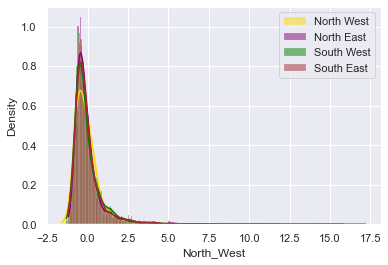

F_onewayResult(statistic=1219.4567735967246, pvalue=0.0)

In [87]:
df_lat_long_punnet['price'] = df.price

North_West = df_lat_long_punnet[df_lat_long_punnet['North_West']].price

North_East = df_lat_long_punnet[df_lat_long_punnet['North_East']].price

South_West = df_lat_long_punnet[df_lat_long_punnet['South_West']].price

South_East = df_lat_long_punnet[df_lat_long_punnet['South_East']].price

Punnet_df = pd.DataFrame([North_West,North_East,South_West,South_East]).T

sns.set(style="darkgrid")

Punnet_df = pd.DataFrame([North_West,North_East,South_West,South_East]).T

Punnet_df.columns.values[0] = "North_West"

Punnet_df.columns.values[1] = "North_East"

Punnet_df.columns.values[2] = "South_West"

Punnet_df.columns.values[3] = "South_East"

df = Punnet_df

sns.histplot(data=df.apply(standardize_scale), x="North_West", color="gold", label="North West", kde=True , stat = 'density')

sns.histplot(data=df.apply(standardize_scale), x="North_East", color="purple", label="North East", kde=True , stat = 'density')

sns.histplot(data=df.apply(standardize_scale), x="South_West", color="green", label="South West", kde=True , stat = 'density')

sns.histplot(data=df.apply(standardize_scale), x="South_East", color="brown", label="South East", kde=True , stat = 'density')


plt.legend() 

plt.show()

stats.f_oneway(North_West, North_East, South_West, South_East)

---------------------------------------------------------------------------------------------------------

F_onewayResult(statistic=1790.0484329706985, pvalue=0.0)

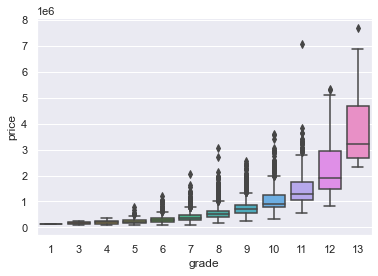

In [106]:
df = pd.read_csv("kc_house_data_train.csv", index_col=[0])

grade_8 = df[df.grade == 8].price.values

grade_11 = df[df.grade == 11].price.values

grade_12 = df[df.grade == 12].price.values

grade_9 = df[df.grade == 9].price.values

grade_7 = df[df.grade == 7].price.values

grade_6 = df[df.grade == 6].price.values

grade_5 = df[df.grade == 5].price.values

grade_13 = df[df.grade == 13].price.values

grade_4 = df[df.grade == 4].price.values

grade_3 = df[df.grade == 3].price.values

grade_1 = df[df.grade == 1].price.values

sns.boxplot( x=df["grade"], y=df["price"])

stats.f_oneway(grade_8,grade_11,grade_12,grade_9,grade_7,grade_6,grade_5,grade_13,grade_4 , grade_3,grade_1)

-----------------------------------------------------

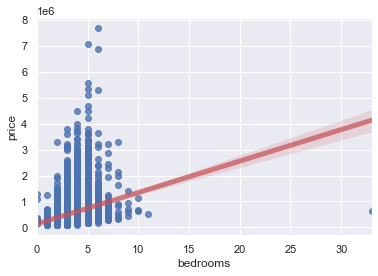

In [109]:
sns.regplot(x=df['bedrooms'], y=df["price"], line_kws={"color":"r","alpha":0.7,"lw":5})
plt.show()

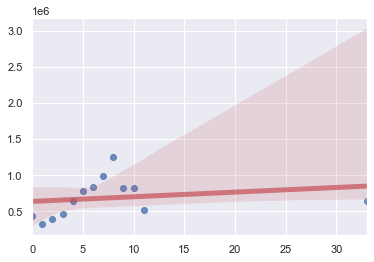

In [112]:
sns.regplot(x=list(df.groupby('bedrooms')['price'].mean().index), y=list(df.groupby('bedrooms')['price'].mean().values), line_kws={"color":"r","alpha":0.7,"lw":5})
plt.show()

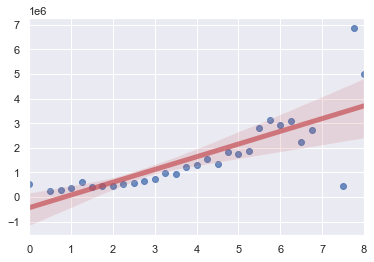

In [113]:
sns.regplot(x=list(df.groupby('bathrooms')['price'].mean().index), y=list(df.groupby('bathrooms')['price'].mean().values), line_kws={"color":"r","alpha":0.7,"lw":5})
import pandas as pd

plt.show()